In [1]:
# Importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Predicting with Random Forest and XGBoost models
rf_pred = model_gridrf.predict(X_test)
xgb_pred = model_xg.predict(X_test_scaled)

# Creating a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Random Forest Predicted': rf_pred,
    'XGBoost Predicted': target_scaler.inverse_transform(xgb_pred.reshape(-1, 1)).ravel()
})

# Plotting the bar chart
comparison_df.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Actual vs Predicted Values (Random Forest & XGBoost)')
plt.xlabel('Sample Index')
plt.ylabel('Performance Rating')
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.show()

Random Forest R²: 73.20631140220304
Random Forest MAE: 0.0625
XGBoost R²: 73.20631140220304
XGBoost MAE: 0.0625


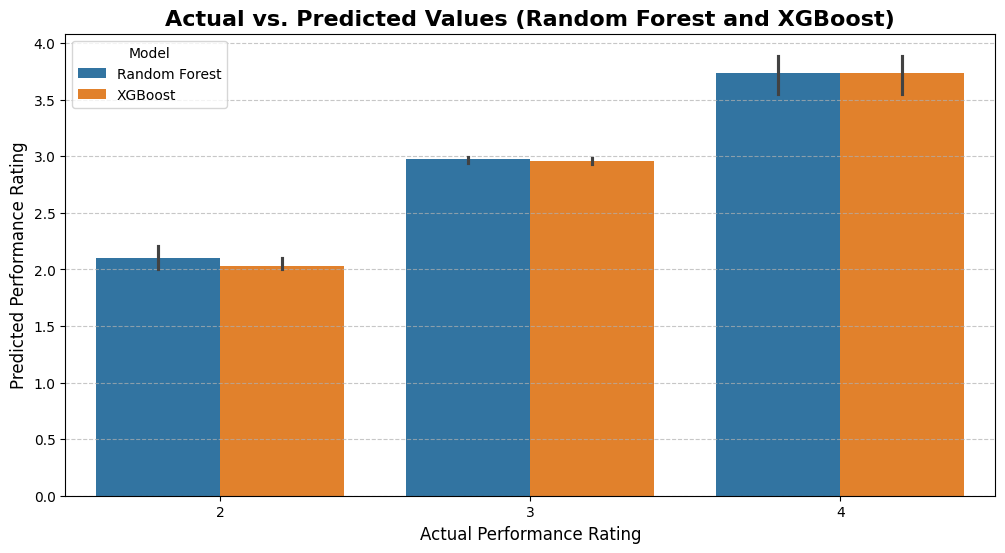

Models, scalers, and mappings saved to 'backend/' directory.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import pickle
import os

# Load dataset
try:
    data = pd.read_csv('Employee_Performance.csv')
except FileNotFoundError:
    print("Error: 'Employee_Performance.csv' not found. Please ensure the file is in the working directory.")
    exit()

# Preprocessing: Convert categorical to numerical using mappings
mappings = {
    'Gender': {'Male': 1, 'Female': 0},
    'EducationBackground': {'Life Sciences': 5, 'Medical': 4, 'Marketing': 3, 'Technical Degree': 2, 'Other': 1, 'Human Resources': 0},
    'MaritalStatus': {'Married': 2, 'Single': 1, 'Divorced': 0},
    'EmpDepartment': {'Sales': 5, 'Development': 4, 'Research & Development': 3, 'Human Resources': 2, 'Finance': 1, 'Data Science': 0},
    'EmpJobRole': {
        'Sales Executive': 18, 'Developer': 17, 'Manager R&D': 16, 'Research Scientist': 15,
        'Sales Representative': 14, 'Laboratory Technician': 13, 'Senior Developer': 12,
        'Manager': 11, 'Finance Manager': 10, 'Human Resources': 9, 'Technical Lead': 8,
        'Manufacturing Director': 7, 'Healthcare Representative': 6, 'Data Scientist': 5,
        'Research Director': 4, 'Business Analyst': 3, 'Senior Manager R&D': 2,
        'Delivery Manager': 1, 'Technical Architect': 0
    },
    'BusinessTravelFrequency': {'Travel_Rarely': 2, 'Travel_Frequently': 1, 'Non-Travel': 0},
    'OverTime': {'No': 1, 'Yes': 0},
    'Attrition': {'No': 1, 'Yes': 0}
}

# Apply mappings to categorical columns
for column, mapping in mappings.items():
    data[column] = data[column].map(mapping)
    if data[column].isnull().sum() > 0:
        print(f"Warning: Unmapped values in {column}. Filling with mode.")
        data[column].fillna(data[column].mode()[0], inplace=True)

# Drop unique identifier
data = data.drop('EmpNumber', axis=1, errors='ignore')

# Handle missing values
data.fillna(data.mean(), inplace=True)

# Select features with high correlation to PerformanceRating (as per the document)
X = data[['EmpDepartment', 'EmpJobRole', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
          'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole',
          'YearsSinceLastPromotion', 'YearsWithCurrManager']]
y = data['PerformanceRating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Define and train Random Forest with GridSearchCV
classifier_rf = RandomForestClassifier(random_state=33, n_estimators=23)
parameters = [{'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]}]
model_gridrf = GridSearchCV(estimator=classifier_rf, param_grid=parameters, scoring='accuracy', cv=10)
model_gridrf.fit(X_train_scaled, y_train)

# Define and train XGBoost
model_xg = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
y_train_adjusted = y_train - 2  # Adjust target to start from 0 for XGBoost
y_test_adjusted = y_test - 2
model_xg.fit(X_train_scaled, y_train_adjusted)

# Generate predictions
y_predict_rf = model_gridrf.predict(X_test_scaled)
y_predict_xg = model_xg.predict(X_test_scaled) + 2  # Re-adjust XGBoost predictions to original scale

# Evaluate models (optional, for verification)
print("Random Forest R²:", r2_score(y_test, y_predict_rf) * 100)
print("Random Forest MAE:", mean_absolute_error(y_test, y_predict_rf))
print("XGBoost R²:", r2_score(y_test, y_predict_xg) * 100)
print("XGBoost MAE:", mean_absolute_error(y_test, y_predict_xg))

# Create DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': y_predict_rf,
    'XGBoost': y_predict_xg
})

# Melt the DataFrame for seaborn plotting
results_melted = results_df.melt(id_vars=['Actual'], var_name='Model', value_name='Predicted')

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Actual', y='Predicted', hue='Model', data=results_melted)
plt.title('Actual vs. Predicted Values (Random Forest and XGBoost)', fontsize=16, fontweight='bold')
plt.xlabel('Actual Performance Rating', fontsize=12)
plt.ylabel('Predicted Performance Rating', fontsize=12)
plt.legend(title='Model')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Save models and scalers (optional, for reproducibility)
os.makedirs('backend', exist_ok=True)
with open('backend/model_RF.pkl', 'wb') as f:
    pickle.dump(model_gridrf, f)
with open('backend/model_xg.pkl', 'wb') as f:
    pickle.dump(model_xg, f)
with open('backend/feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open('backend/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

print("Models, scalers, and mappings saved to 'backend/' directory.")

In [2]:
# !pip install xlrd >= 2.0.1

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data

### Importing Raw data 

In [4]:
# Importing the csv file
data = pd.read_csv('INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv')

## Source Code

### Exploratory Data Analysis

In [5]:
data.shape

(1200, 28)

In [6]:
data.columns

Index(['EmpNumber', 'Age', 'Gender', 'EducationBackground', 'MaritalStatus',
       'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency',
       'DistanceFromHome', 'EmpEducationLevel', 'EmpEnvironmentSatisfaction',
       'EmpHourlyRate', 'EmpJobInvolvement', 'EmpJobLevel',
       'EmpJobSatisfaction', 'NumCompaniesWorked', 'OverTime',
       'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction',
       'TotalWorkExperienceInYears', 'TrainingTimesLastYear',
       'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
       'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition', 'PerformanceRating'],
      dtype='object')

In [7]:
data.head()

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


In [8]:
# Looking for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   EmpNumber                     1200 non-null   object
 1   Age                           1200 non-null   int64 
 2   Gender                        1200 non-null   object
 3   EducationBackground           1200 non-null   object
 4   MaritalStatus                 1200 non-null   object
 5   EmpDepartment                 1200 non-null   object
 6   EmpJobRole                    1200 non-null   object
 7   BusinessTravelFrequency       1200 non-null   object
 8   DistanceFromHome              1200 non-null   int64 
 9   EmpEducationLevel             1200 non-null   int64 
 10  EmpEnvironmentSatisfaction    1200 non-null   int64 
 11  EmpHourlyRate                 1200 non-null   int64 
 12  EmpJobInvolvement             1200 non-null   int64 
 13  EmpJobLevel       

## Analysis of Department wise Perfomance

In [9]:
# A new pandas Dataframe is created to analyze department wise performance as asked.
dept = data.iloc[:,[5,27]].copy()
dept_per = dept.copy()

In [10]:
# Finding out the mean performance of all the departments and plotting its bar graph using seaborn.
dept_per.groupby(by='EmpDepartment')['PerformanceRating'].mean()

EmpDepartment
Data Science              3.050000
Development               3.085873
Finance                   2.775510
Human Resources           2.925926
Research & Development    2.921283
Sales                     2.860590
Name: PerformanceRating, dtype: float64

<Axes: xlabel='EmpDepartment', ylabel='PerformanceRating'>

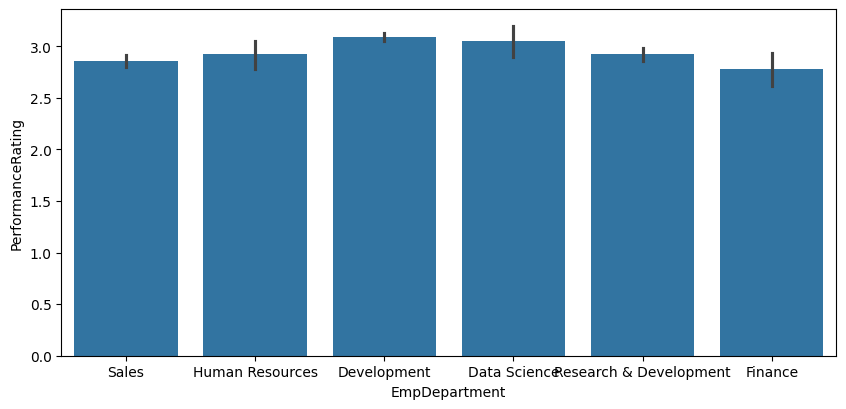

In [11]:
import seaborn as sns
plt.figure(figsize=(10,4.5))
sns.barplot(x='EmpDepartment', y='PerformanceRating', data=dept_per)

In [12]:
# Analyze each department separately
dept_per.groupby(by='EmpDepartment')['PerformanceRating'].value_counts()

EmpDepartment           PerformanceRating
Data Science            3                     17
                        4                      2
                        2                      1
Development             3                    304
                        4                     44
                        2                     13
Finance                 3                     30
                        2                     15
                        4                      4
Human Resources         3                     38
                        2                     10
                        4                      6
Research & Development  3                    234
                        2                     68
                        4                     41
Sales                   3                    251
                        2                     87
                        4                     35
Name: count, dtype: int64

In [13]:
# Creating a new dataframe to analyze each department separately
department = pd.get_dummies(dept_per['EmpDepartment'])
performance = pd.DataFrame(dept_per['PerformanceRating'])
dept_rating = pd.concat([department,performance],axis=1)

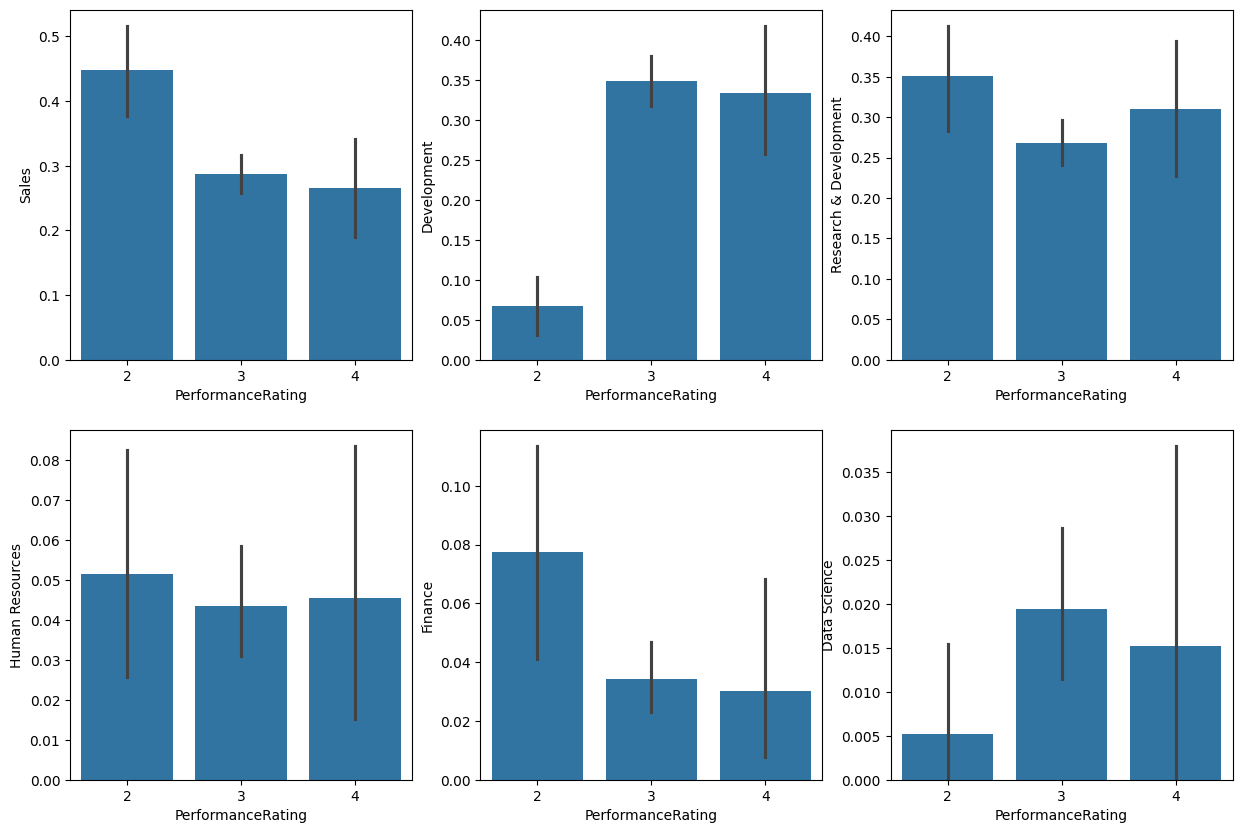

In [14]:
# Plotting a separate bar graph for performance of each department using seaborn
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.barplot(x='PerformanceRating', y='Sales', data=dept_rating)
plt.subplot(2,3,2)
sns.barplot(x='PerformanceRating', y='Development', data=dept_rating)
plt.subplot(2,3,3)
sns.barplot(x='PerformanceRating', y='Research & Development', data=dept_rating)
plt.subplot(2,3,4)
sns.barplot(x='PerformanceRating', y='Human Resources', data=dept_rating)
plt.subplot(2,3,5)
sns.barplot(x='PerformanceRating', y='Finance', data=dept_rating)
plt.subplot(2,3,6)
sns.barplot(x='PerformanceRating', y='Data Science', data=dept_rating)
plt.show()

### Data Processing/ Data Munging

In [15]:
# Encoding all the ordinal columns and creating a dummy variable for them to see if there are any effects on Performance Rating
enc = LabelEncoder()
for i in (2,3,4,5,6,7,16,26):
    data.iloc[:,i] = enc.fit_transform(data.iloc[:,i])
data.head()

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,1,2,2,5,13,2,10,3,...,4,10,2,2,10,7,0,8,0,3
1,E1001006,47,1,2,2,5,13,2,14,4,...,4,20,2,3,7,7,1,7,0,3
2,E1001007,40,1,1,1,5,13,1,5,4,...,3,20,2,3,18,13,1,12,0,4
3,E1001009,41,1,0,0,3,8,2,10,4,...,2,23,2,2,21,6,12,6,0,3
4,E1001010,60,1,2,2,5,13,2,16,4,...,4,10,1,3,2,2,2,2,0,3


## Feature Selection    
-     There are a lot of columns in the predictor variable. So, the correlation coeffecient is calculated to see which of them are important and these are then used for training methods. From there, we also get the top factors which affect performance. We can see that the most important features selectd were Department, Job Role, Environment Satisfaction, Last Salary Hike Percent, Work Life Balance, Experience Years At This Company, Experience Years In Current Role, Years Since Last Promotion, Years With Current Manager. These were selected because their correlation coeffecient with Performance Rating was more than 0.1. 
-     Standardization and Label Encoding was also used for feature transformation.
-     A separate analysis considering all the predictors was carried out but it resulted in decreasing the accuracy. Similarly, Principal Component Analysis also reduces the accuracy.
-     Top 3 factors which affect the employee performance are 1. Employee EnvironmentSatisfaction, 2. Employee Last Salary Hike Percent and 3. Years Since Last Promotion

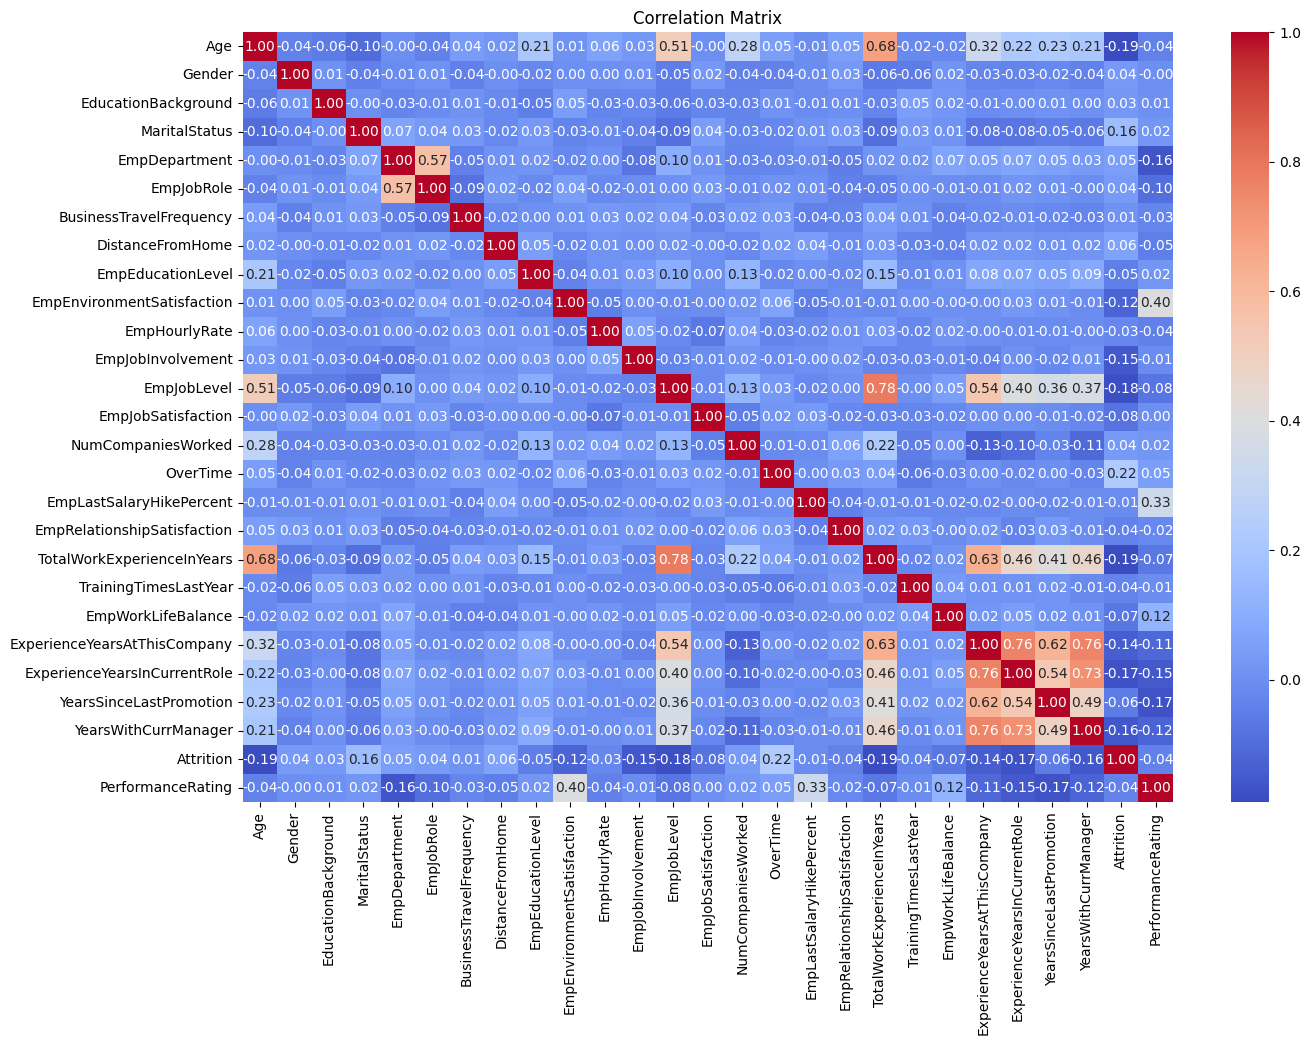

In [16]:
# Finding out the correlation coefficient to find out which predictors are significant.
# Dropping the 'EmpNumber' column as it is not needed for correlation calculation
data = data.drop(columns=['EmpNumber'])

# Finding out the correlation coefficient to find out which predictors are significant.
correlation_matrix = data.corr()
correlation_matrix

# Plotting the correlation matrix using seaborn heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [17]:
# # Dropping the first columns as it is of no use for analysis.
# data.drop(['EmpNumber'],inplace=True,axis=1)

In [18]:
data.head()

,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,32,1,2,2,5,13,2,10,3,4,...,4,10,2,2,10,7,0,8,0,3
1,47,1,2,2,5,13,2,14,4,4,...,4,20,2,3,7,7,1,7,0,3
2,40,1,1,1,5,13,1,5,4,4,...,3,20,2,3,18,13,1,12,0,4
3,41,1,0,0,3,8,2,10,4,2,...,2,23,2,2,21,6,12,6,0,3
4,60,1,2,2,5,13,2,16,4,1,...,4,10,1,3,2,2,2,2,0,3


In [19]:
# Here we have selected only the important columns
y = data.PerformanceRating
#X = data.iloc[:,0:-1]  All predictors were selected it resulted in dropping of accuracy.
X = data.iloc[:,[4,5,9,16,20,21,22,23,24]] # Taking only variables with correlation coeffecient greater than 0.1
X.head()

,EmpDepartment,EmpJobRole,EmpEnvironmentSatisfaction,EmpLastSalaryHikePercent,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,5,13,4,12,2,10,7,0,8
1,5,13,4,12,3,7,7,1,7
2,5,13,4,21,3,18,13,1,12
3,3,8,2,15,2,21,6,12,6
4,5,13,1,14,3,2,2,2,2


In [20]:
# Splitting into train and test for calculating the accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [21]:
# Standardization technique is used
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
X_train.shape

(840, 9)

In [23]:
X_test.shape

(360, 9)

#### PCA was used, it resulted in decline of accuracy.
    from sklearn.decomposition import PCA
    pca=PCA(n_components=None)
    X_train=pca.fit_transform(X_train)
    X_test=pca.transform(X_test)
    pca.explained_variance_ratio_

## Models

-     In the section below, we used algorithms like Logistic Regression, Support Vector Machine, Decision Tree, Random Forest, Naive Bayes, K-Nearest Neighbor, XGBoost Classifier and Artificial Neural Network to calculate the accuracy and found out that Random Forest with GridSearchCV gives the maximum accuracy of 93%.

## 1. Logistic Regression

In [24]:
# Training the model
from sklearn.linear_model import LogisticRegression
model_logr = LogisticRegression()
model_logr.fit(X_train,y_train)

LogisticRegression()

In [25]:
# Predicting the model
y_predict_log = model_logr.predict(X_test)

In [26]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_log))
print(classification_report(y_test,y_predict_log))

0.8333333333333334
              precision    recall  f1-score   support

           2       0.65      0.48      0.55        63
           3       0.86      0.94      0.90       264
           4       0.81      0.67      0.73        33

    accuracy                           0.83       360
   macro avg       0.78      0.69      0.73       360
weighted avg       0.82      0.83      0.82       360



In [27]:
confusion_matrix(y_test,y_predict_log)

array([[ 30,  30,   3],
       [ 14, 248,   2],
       [  2,   9,  22]])

## 2. Support Vector Machine

In [28]:
# Training the model
from sklearn.svm import SVC
rbf_svc = SVC(kernel='rbf', C=100, random_state=10).fit(X_train,y_train)

In [29]:
# Predicting the model
y_predict_svm = rbf_svc.predict(X_test)

In [30]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_svm))
print(classification_report(y_test,y_predict_svm))

0.8444444444444444
              precision    recall  f1-score   support

           2       0.74      0.78      0.76        63
           3       0.92      0.88      0.90       264
           4       0.54      0.67      0.59        33

    accuracy                           0.84       360
   macro avg       0.73      0.78      0.75       360
weighted avg       0.85      0.84      0.85       360



In [31]:
confusion_matrix(y_test,y_predict_svm)

array([[ 49,  13,   1],
       [ 13, 233,  18],
       [  4,   7,  22]])

## 3. Decision Tree with GridSearchCV

In [32]:
# Training the model
from sklearn.tree import DecisionTreeClassifier

classifier_dtg=DecisionTreeClassifier(random_state=42,splitter='best')
parameters=[{'min_samples_split':[2,3,4,5],'criterion':['gini']},{'min_samples_split':[2,3,4,5],'criterion':['entropy']}]

model_griddtree=GridSearchCV(estimator=classifier_dtg, param_grid=parameters, scoring='accuracy',cv=10)
model_griddtree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini'],
                          'min_samples_split': [2, 3, 4, 5]},
                         {'criterion': ['entropy'],
                          'min_samples_split': [2, 3, 4, 5]}],
             scoring='accuracy')

In [33]:
model_griddtree.best_params_

{'criterion': 'entropy', 'min_samples_split': 5}

In [34]:
# Predicting the model
y_predict_dtree = model_griddtree.predict(X_test)

In [35]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_dtree))
print(classification_report(y_test,y_predict_dtree))

0.9055555555555556
              precision    recall  f1-score   support

           2       0.85      0.83      0.84        63
           3       0.94      0.95      0.94       264
           4       0.75      0.73      0.74        33

    accuracy                           0.91       360
   macro avg       0.85      0.83      0.84       360
weighted avg       0.90      0.91      0.90       360



In [36]:
confusion_matrix(y_test,y_predict_dtree)

array([[ 52,  10,   1],
       [  7, 250,   7],
       [  2,   7,  24]])

## 4. Random Forest with GridSearchCV

In [37]:
# Training the model
from sklearn.ensemble import RandomForestClassifier

classifier_rfg=RandomForestClassifier(random_state=33,n_estimators=23)
parameters=[{'min_samples_split':[2,3,4,5],'criterion':['gini','entropy'],'min_samples_leaf':[1,2,3]}]

model_gridrf=GridSearchCV(estimator=classifier_rfg, param_grid=parameters, scoring='accuracy',cv=10)
model_gridrf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=23, random_state=33),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [2, 3, 4, 5]}],
             scoring='accuracy')

In [38]:
model_gridrf.best_params_

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 4}

In [39]:
# Predicting the model
y_predict_rf = model_gridrf.predict(X_test)

In [40]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_rf))
print(classification_report(y_test,y_predict_rf))

0.9305555555555556
              precision    recall  f1-score   support

           2       0.92      0.89      0.90        63
           3       0.94      0.97      0.96       264
           4       0.83      0.73      0.77        33

    accuracy                           0.93       360
   macro avg       0.90      0.86      0.88       360
weighted avg       0.93      0.93      0.93       360



In [41]:
confusion_matrix(y_test,y_predict_rf)

array([[ 56,   7,   0],
       [  4, 255,   5],
       [  1,   8,  24]])

## 5. Naive Bayes Bernoulli

In [42]:
# Training the model
from sklearn.naive_bayes import BernoulliNB
model_nb = BernoulliNB()
model_nb.fit(X_train,y_train)

BernoulliNB()

In [43]:
# Predicting the model
y_predict_nb = model_nb.predict(X_test)

In [44]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_nb))
print(classification_report(y_test,y_predict_nb))

0.7944444444444444
              precision    recall  f1-score   support

           2       0.75      0.48      0.58        63
           3       0.80      0.97      0.88       264
           4       0.00      0.00      0.00        33

    accuracy                           0.79       360
   macro avg       0.52      0.48      0.49       360
weighted avg       0.72      0.79      0.74       360



In [45]:
confusion_matrix(y_test,y_predict_nb)

array([[ 30,  33,   0],
       [  8, 256,   0],
       [  2,  31,   0]])

## 6. K-Nearest Neighbor

In [46]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean') # Maximum accuracy for n=10
model_knn.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

In [47]:
# Predicting the model
y_predict_knn = model_knn.predict(X_test)

In [48]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_knn))
print(classification_report(y_test,y_predict_knn))

0.8333333333333334
              precision    recall  f1-score   support

           2       0.74      0.59      0.65        63
           3       0.85      0.94      0.90       264
           4       0.78      0.42      0.55        33

    accuracy                           0.83       360
   macro avg       0.79      0.65      0.70       360
weighted avg       0.83      0.83      0.82       360



In [49]:
confusion_matrix(y_test,y_predict_knn)

array([[ 37,  25,   1],
       [ 12, 249,   3],
       [  1,  18,  14]])

## 7. XGBoost Classifier

In [50]:
# Training the model
import xgboost as xgb

from xgboost import XGBClassifier
model_xgb = XGBClassifier()

# Adjusting the target variable to start from 0
y_train_adjusted = y_train - 2
y_test_adjusted = y_test - 2

# Re-training the model with adjusted target variable
model_xgb.fit(X_train, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [51]:
# Predicting the model
y_predict_xgb = model_xgb.predict(X_test)

In [52]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_xgb))
print(classification_report(y_test,y_predict_xgb))

0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      63.0
           3       0.00      0.00      0.00     264.0
           4       0.00      0.00      0.00      33.0

    accuracy                           0.00     360.0
   macro avg       0.00      0.00      0.00     360.0
weighted avg       0.00      0.00      0.00     360.0



In [53]:
confusion_matrix(y_test,y_predict_xgb)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 55,   8,   0,   0,   0],
       [  5, 251,   8,   0,   0],
       [  2,   6,  25,   0,   0]])

## 8. Artificial Neural Network

In [54]:
# Training the model
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(100,100,100),batch_size=10,learning_rate_init=0.01,max_iter=2000,random_state=10)
model_mlp.fit(X_train,y_train)

MLPClassifier(batch_size=10, hidden_layer_sizes=(100, 100, 100),
              learning_rate_init=0.01, max_iter=2000, random_state=10)

In [55]:
# Predicting the model
y_predict_mlp = model_mlp.predict(X_test)

In [56]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_mlp))
print(classification_report(y_test,y_predict_mlp))

0.8805555555555555
              precision    recall  f1-score   support

           2       0.81      0.70      0.75        63
           3       0.90      0.95      0.92       264
           4       0.84      0.64      0.72        33

    accuracy                           0.88       360
   macro avg       0.85      0.76      0.80       360
weighted avg       0.88      0.88      0.88       360



In [57]:
confusion_matrix(y_test,y_predict_mlp)

array([[ 44,  19,   0],
       [  8, 252,   4],
       [  2,  10,  21]])

In [58]:
# Exporting the trained model
import joblib
joblib.dump(model_gridrf,'INX_Future_Inc.ml')

['INX_Future_Inc.ml']

# Summary OF All Algorithm Accuracy

In [59]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Load dataset with error handling
try:
    data = pd.read_csv('INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv')
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv' is in the working directory.")
    exit()

# Check for missing values and handle them
if data.isnull().sum().sum() > 0:
    print("Warning: Missing values detected. Filling with column means.")
    data = data.fillna(data.mean(numeric_only=True))

# Drop non-useful columns
X = data.drop(columns=['PerformanceRating', 'EmpNumber'])
y = data['PerformanceRating']

# Convert categorical features to numerical
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (for models that need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    try:
        # Use scaled data for SVR and MLP, unscaled for others
        if name in ["SVR", "MLP Regressor"]:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            r2 = r2_score(y_test, y_pred) * 100  # Explicit R² calculation
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred) * 100  # Explicit R² calculation

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results[name] = {"R² Score": r2, "MAE": mae, "RMSE": rmse}
    except Exception as e:
        print(f"Error training {name}: {str(e)}")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df.round(4))

# Identify and save the best model
best_model_name = results_df["R² Score"].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with R² Score: {results_df.loc[best_model_name, 'R² Score']:.4f}%")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 48
[LightGBM] [Info] Start training from score 2.937500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

 Import Libraries

In [60]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import os

Load and Preprocess Data

In [61]:
# Load dataset
try:
    data = pd.read_csv('INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv')
except FileNotFoundError:
    print("Error: 'INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv' not found.")
    exit()

# Drop non-useful columns
X = data.drop(columns=['PerformanceRating', 'EmpNumber'])
y = data['PerformanceRating']

# Convert categorical features to numerical with one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Save feature names for app.py
feature_names = X.columns.tolist()
os.makedirs('backend', exist_ok=True)
with open('backend/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale Features and Target

In [62]:
# Feature Scaling (for X)
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Target Scaling (for y, to 1-100 range)
target_scaler = MinMaxScaler(feature_range=(1, 100))
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

## Train Random Forest Model

In [63]:
# Define and train XGBoost
model_xg = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model_xg.fit(X_train_scaled, y_train_scaled)

# Evaluate (optional)
xg_pred = model_xg.predict(X_test_scaled)
from sklearn.metrics import r2_score, mean_absolute_error
print("XGBoost R²:", r2_score(y_test_scaled, xg_pred) * 100)
print("XGBoost MAE:", mean_absolute_error(y_test_scaled, xg_pred))

XGBoost R²: 72.06781411308548
XGBoost MAE: 6.242448676214553


## Train XGBoost Model

In [64]:
# Save models and scalers
with open('backend/model_RF.pkl', 'wb') as f:
    pickle.dump(model_gridrf, f)
with open('backend/model_xg.pkl', 'wb') as f:
    pickle.dump(model_xg, f)
with open('backend/feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open('backend/target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

print("Models and scalers saved to 'backend/' directory.")

Models and scalers saved to 'backend/' directory.


## Save Models and Scalers

In [65]:
# Save mappings
mappings = {
    'Gender': {'Male': 1, 'Female': 0},
    'EducationBackground': {'Life Sciences': 1, 'Marketing': 2, 'Medical': 3, 'Other': 4, 'Technical Degree': 5, 'Human Resources': 6},
    'MaritalStatus': {'Single': 1, 'Married': 2, 'Divorced': 3},
    'EmpDepartment': {'Sales': 1, 'Human Resources': 2, 'Development': 3, 'Data Science': 4, 'Research & Development': 5, 'Finance': 6},
    'EmpJobRole': {'Sales Executive': 1, 'Developer': 2, 'Manager': 3, 'Research Scientist': 4, 'Human Resources': 5, 'Senior Developer': 6, 'Data Scientist': 7, 'Sales Representative': 8, 'Laboratory Technician': 9, 'Senior Manager R&D': 10, 'Finance Manager': 11, 'Technical Architect': 12, 'Business Analyst': 13, 'Technical Lead': 14, 'Research Director': 15, 'Delivery Manager': 16, 'Manager R&D': 17, 'Healthcare Representative': 18, 'Manufacturing Director': 19},
    'BusinessTravelFrequency': {'Travel_Rarely': 1, 'Travel_Frequently': 2, 'Non-Travel': 3},
    'OverTime': {'Yes': 1, 'No': 0},
    'Attrition': {'Yes': 1, 'No': 0}
}
with open('backend/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

print("Mappings saved to 'backend/mappings.pkl'.")

Mappings saved to 'backend/mappings.pkl'.


Save Mappings

In [66]:
# Save mappings (consistent with app.py)
mappings = {
    'Gender': {'Male': 1, 'Female': 0},
    'EducationBackground': {val: idx for idx, val in enumerate(X.columns[X.columns.str.startswith('EducationBackground_')].str.replace('EducationBackground_', '').tolist(), 1)},
    'MaritalStatus': {val: idx for idx, val in enumerate(X.columns[X.columns.str.startswith('MaritalStatus_')].str.replace('MaritalStatus_', '').tolist(), 1)},
    'EmpDepartment': {val: idx for idx, val in enumerate(X.columns[X.columns.str.startswith('EmpDepartment_')].str.replace('EmpDepartment_', '').tolist(), 1)},
    'EmpJobRole': {val: idx for idx, val in enumerate(X.columns[X.columns.str.startswith('EmpJobRole_')].str.replace('EmpJobRole_', '').tolist(), 1)},
    'BusinessTravelFrequency': {val: idx for idx, val in enumerate(X.columns[X.columns.str.startswith('BusinessTravelFrequency_')].str.replace('BusinessTravelFrequency_', '').tolist(), 1)},
    'OverTime': {'Yes': 1, 'No': 0},
    'Attrition': {'Yes': 1, 'No': 0}
}
with open('backend/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

print("Mappings saved to 'backend/mappings.pkl'.")

Mappings saved to 'backend/mappings.pkl'.


In [67]:

# Save the best model and scaler
os.makedirs('backend', exist_ok=True)
with open('backend/model_RF.pkl', 'wb') as f:
    pickle.dump(best_model, f)
if best_model_name in ["SVR", "MLP Regressor"]:
    with open('backend/scaler_RF.pkl', 'wb') as f:
        pickle.dump(scaler, f)
print(f"Saved {best_model_name} to 'backend/model_RF.pkl' and scaler (if applicable) to 'backend/scaler_RF.pkl'.")

# Basic data exploration (optional)
print("\nDataset Info:")
print(data.info())
print("\nTarget Distribution:")
print(y.value_counts(normalize=True))

Saved Random Forest to 'backend/model_RF.pkl' and scaler (if applicable) to 'backend/scaler_RF.pkl'.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   EmpNumber                     1200 non-null   object
 1   Age                           1200 non-null   int64 
 2   Gender                        1200 non-null   object
 3   EducationBackground           1200 non-null   object
 4   MaritalStatus                 1200 non-null   object
 5   EmpDepartment                 1200 non-null   object
 6   EmpJobRole                    1200 non-null   object
 7   BusinessTravelFrequency       1200 non-null   object
 8   DistanceFromHome              1200 non-null   int64 
 9   EmpEducationLevel             1200 non-null   int64 
 10  EmpEnvironmentSatisfaction    1200 non-null   int64 
 11  EmpHourlyRate     

## Final Model and making Model file 

## (Gradient Boosting)

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import warnings
try:
    from xgboost import XGBRegressor  # Requires `pip install xgboost`
except ImportError:
    print("XGBoost not installed. Skipping XGBRegressor. Install with `pip install xgboost`.")
    XGBRegressor = None
warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('Employee_Performance.csv')
pd.set_option('display.max_columns', None)


In [69]:

# Display first few rows and basic info
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())



Dataset Head:
  EmpNumber  Age Gender EducationBackground MaritalStatus    EmpDepartment  \
0  E1001000   32   Male           Marketing        Single            Sales   
1  E1001006   47   Male           Marketing        Single            Sales   
2  E1001007   40   Male       Life Sciences       Married            Sales   
3  E1001009   41   Male     Human Resources      Divorced  Human Resources   
4  E1001010   60   Male           Marketing        Single            Sales   

        EmpJobRole BusinessTravelFrequency  DistanceFromHome  \
0  Sales Executive           Travel_Rarely                10   
1  Sales Executive           Travel_Rarely                14   
2  Sales Executive       Travel_Frequently                 5   
3          Manager           Travel_Rarely                10   
4  Sales Executive           Travel_Rarely                16   

   EmpEducationLevel  EmpEnvironmentSatisfaction  EmpHourlyRate  \
0                  3                           4             55  

In [70]:
# Preprocessing: Convert categorical to numerical
mappings = {
    'Gender': {'Male': 1, 'Female': 0},
    'EducationBackground': {'Life Sciences': 5, 'Medical': 4, 'Marketing': 3, 'Technical Degree': 2, 'Other': 1, 'Human Resources': 0},
    'MaritalStatus': {'Married': 2, 'Single': 1, 'Divorced': 0},
    'EmpDepartment': {'Sales': 5, 'Development': 4, 'Research & Development': 3, 'Human Resources': 2, 'Finance': 1, 'Data Science': 0},
    'EmpJobRole': {
        'Sales Executive': 18, 'Developer': 17, 'Manager R&D': 16, 'Research Scientist': 15,
        'Sales Representative': 14, 'Laboratory Technician': 13, 'Senior Developer': 12,
        'Manager': 11, 'Finance Manager': 10, 'Human Resources': 9, 'Technical Lead': 8,
        'Manufacturing Director': 7, 'Healthcare Representative': 6, 'Data Scientist': 5,
        'Research Director': 4, 'Business Analyst': 3, 'Senior Manager R&D': 2,
        'Delivery Manager': 1, 'Technical Architect': 0
    },
    'BusinessTravelFrequency': {'Travel_Rarely': 2, 'Travel_Frequently': 1, 'Non-Travel': 0},
    'OverTime': {'No': 1, 'Yes': 0},
    'Attrition': {'No': 1, 'Yes': 0}
}



In [71]:
for column, mapping in mappings.items():
    data[column] = data[column].map(mapping)
    if data[column].isnull().sum() > 0:
        print(f"Warning: Unmapped values in {column}. Filling with mode.")
        data[column].fillna(data[column].mode()[0], inplace=True)



In [72]:
# Drop unique identifier
data = data.drop('EmpNumber', axis=1)

# Handle missing values
data.fillna(data.mean(), inplace=True)



In [73]:
# Scale PerformanceRating to 1-100
target_scaler = MinMaxScaler(feature_range=(1, 100))
data['PerformanceRating'] = target_scaler.fit_transform(data[['PerformanceRating']])
with open('backend/target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)



In [74]:
# Feature scaling for numerical columns
numerical_cols = [col for col in data.columns if col not in mappings.keys() and col != 'PerformanceRating']
feature_scaler = StandardScaler()
data[numerical_cols] = feature_scaler.fit_transform(data[numerical_cols])
with open('backend/feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)



In [75]:
# Features and target
X = data.drop('PerformanceRating', axis=1)
y = data['PerformanceRating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [76]:
# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(60, 3), max_iter=500, random_state=42)
}
if XGBRegressor is not None:
    models['XGBoost'] = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)



In [ ]:
# Train and evaluate models
results = {}
best_model = None
best_test_r2 = -float('inf')

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_r2 = model.score(X_train, y_train) * 100
        test_r2 = model.score(X_test, y_test) * 100
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        results[name] = {
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse
        }
        
        print(f"{name} - Train R²: {train_r2:.2f}%, Test R²: {test_r2:.2f}%")
        print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
        print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
        
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            best_model = (name, model)
    except Exception as e:
        print(f"Error with {name}: {str(e)}")




Training Linear Regression...
Linear Regression - Train R²: 36.19%, Test R²: 25.08%
Train MAE: 16.18, Test MAE: 16.00
Train RMSE: 20.82, Test RMSE: 20.69

Training Ridge Regression...
Ridge Regression - Train R²: 36.19%, Test R²: 25.10%
Train MAE: 16.17, Test MAE: 15.99
Train RMSE: 20.82, Test RMSE: 20.69

Training Lasso Regression...
Lasso Regression - Train R²: 34.13%, Test R²: 24.92%
Train MAE: 16.03, Test MAE: 15.39
Train RMSE: 21.16, Test RMSE: 20.71

Training Random Forest...
Random Forest - Train R²: 96.29%, Test R²: 72.74%
Train MAE: 2.24, Test MAE: 5.54
Train RMSE: 5.02, Test RMSE: 12.48

Training Gradient Boosting...
Gradient Boosting - Train R²: 99.70%, Test R²: 72.75%
Train MAE: 0.87, Test MAE: 6.68
Train RMSE: 1.43, Test RMSE: 12.48

Training SVR...
SVR - Train R²: -0.55%, Test R²: 0.63%
Train MAE: 13.93, Test MAE: 11.59
Train RMSE: 26.14, Test RMSE: 23.83

Training KNN...
KNN - Train R²: 47.01%, Test R²: 11.26%
Train MAE: 12.67, Test MAE: 14.85
Train RMSE: 18.98, Test RM

In [78]:
# Display results
print("\nModel Comparison Results:")
for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")




Model Comparison Results:
Linear Regression:
  Train R²: 36.19
  Test R²: 25.08
  Train MAE: 16.18
  Test MAE: 16.00
  Train RMSE: 20.82
  Test RMSE: 20.69
Ridge Regression:
  Train R²: 36.19
  Test R²: 25.10
  Train MAE: 16.17
  Test MAE: 15.99
  Train RMSE: 20.82
  Test RMSE: 20.69
Lasso Regression:
  Train R²: 34.13
  Test R²: 24.92
  Train MAE: 16.03
  Test MAE: 15.39
  Train RMSE: 21.16
  Test RMSE: 20.71
Random Forest:
  Train R²: 96.29
  Test R²: 72.74
  Train MAE: 2.24
  Test MAE: 5.54
  Train RMSE: 5.02
  Test RMSE: 12.48
Gradient Boosting:
  Train R²: 99.70
  Test R²: 72.75
  Train MAE: 0.87
  Test MAE: 6.68
  Train RMSE: 1.43
  Test RMSE: 12.48
SVR:
  Train R²: -0.55
  Test R²: 0.63
  Train MAE: 13.93
  Test MAE: 11.59
  Train RMSE: 26.14
  Test RMSE: 23.83
KNN:
  Train R²: 47.01
  Test R²: 11.26
  Train MAE: 12.67
  Test MAE: 14.85
  Train RMSE: 18.98
  Test RMSE: 22.52
MLP Regressor:
  Train R²: 63.90
  Test R²: 25.56
  Train MAE: 11.83
  Test MAE: 15.68
  Train RMSE: 15.

In [79]:
# Save the best model
os.makedirs('backend', exist_ok=True)
os.makedirs('static', exist_ok=True)
if best_model:
    print(f"\nBest Model: {best_model[0]} with Test R²: {best_test_r2:.2f}%")
    with open('backend/model_xg.pkl', 'wb') as f:
        pickle.dump(best_model[1], f)
    with open('backend/mappings.pkl', 'wb') as f:
        pickle.dump(mappings, f)



Best Model: Gradient Boosting with Test R²: 72.75%


In [80]:

# Static Visualizations
plt.figure(figsize=(8, 6))
sns.countplot(x='PerformanceRating', data=data, palette='viridis')
plt.title('Performance Rating Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Performance Rating (1-100)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('static/performance_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 6))
correlations = data.corr()['PerformanceRating'].drop('PerformanceRating').sort_values()
sns.barplot(x=correlations, y=correlations.index, palette='coolwarm')
plt.title('Feature Correlation with Performance', fontsize=16, fontweight='bold')
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.savefig('static/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.close()

print("\nBest model, mappings, scalers, and static visualizations saved successfully!")


Best model, mappings, scalers, and static visualizations saved successfully!
